# Part 1B Data Processing & Feature Engineering

## Setup and Configuration

In [ ]:
# Install required packages
!pip install polars==0.20.31
!pip install lightgbm
!pip install scikit-learn
!pip install tqdm
!pip install implicit

import polars as pl
import pandas as pd
import numpy as np
import gc
import os
import pickle
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from typing import Dict, List, Tuple, Optional
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Memory optimization settings
pl.Config.set_tbl_rows(10)
pl.Config.set_tbl_cols(8)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 36.8 MB/s eta 0:00:00
  Attempting uninstall: polars
    Found existing installation: polars 1.25.2
    Uninstalling polars-1.25.2:
      Successfully uninstalled polars-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-polars-cu12 25.6.0 requires polars<1.29,>=1.25, but you have polars 0.20.31 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 13.1 MB/s eta 0:00:00


polars.config.Config

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

ValueError: Mountpoint must not already contain files

In [4]:
from google.colab import drive
import os

# This command forcefully removes the '/content/drive' directory and all its contents.
# The '!' runs it as a shell command.
!rm -rf /content/drive

# Now, mount your Google Drive again. It will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Configuration settings
class Config:
    # Data paths - update these with your Google Drive paths
    DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/CML/Assignment 1/content/otto-data'
    OUTPUT_PATH = '/content/drive/MyDrive/Colab Notebooks/CML/Assignment 1/content/otto-output'

    # Model parameters
    N_CANDIDATES = 100  # Number of candidates to generate
    TOP_K = 20          # Final recommendations per session type

    # Co-visitation matrix parameters
    CLICK_WEIGHT = 1
    CART_WEIGHT = 6
    ORDER_WEIGHT = 3

    # Time windows for co-visitation
    CLICK_TIME_WINDOW = 24 * 60 * 60  # 24 hours
    CART_ORDER_TIME_WINDOW = 14 * 24 * 60 * 60  # 14 days

    # Memory management
    CHUNK_SIZE = 100000  # Process data in chunks

    # Create output directory
    os.makedirs(OUTPUT_PATH, exist_ok=True)

config = Config()

## Data Loading and Initial Exploration

In [6]:
def load_data_efficiently_parquet(file_path: str) -> pl.DataFrame:
    """
    Load Parquet data efficiently - much faster than JSONL
    """
    print(f"Loading optimized data from {file_path}")

    try:
        # Load Parquet directly - much faster and preserves data types
        df = pl.read_parquet(file_path)
        print(f"Loaded {len(df):,} rows from Parquet file")
        print(f"Data types preserved: {df.dtypes}")
        return df
    except Exception as e:
        print(f"Failed to load Parquet file: {e}")

        # Fallback to JSONL if Parquet fails
        jsonl_path = file_path.replace('.parquet', '.jsonl')
        print(f"Trying fallback to JSONL: {jsonl_path}")

        try:
            df = pl.read_ndjson(jsonl_path)
            print(f"Loaded {len(df):,} rows from JSONL fallback")
            return df
        except Exception as e2:
            print(f"Both Parquet and JSONL loading failed: {e2}")
            raise e2

# Load training data (using optimized Parquet)
print("Loading training data from Parquet...")
train_df = load_data_efficiently_parquet(f"{config.DATA_PATH}/train.parquet")

# Load test data (using optimized Parquet)
print("Loading test data from Parquet...")
test_df = load_data_efficiently_parquet(f"{config.DATA_PATH}/test.parquet")

print(f"\nData Loading Summary:")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Train columns: {train_df.columns}")
print(f"Train dtypes: {train_df.dtypes}")

# Verify data quality
print(f"\nQuick Data Validation:")
print(f"Train sessions: {train_df.select('session').n_unique():,}")
print(f"Test sessions: {test_df.select('session').n_unique():,}")
print(f"Train items: {train_df.select('aid').n_unique():,}")
print(f"Test items: {test_df.select('aid').n_unique():,}")

# Memory usage comparison
train_memory_mb = train_df.estimated_size('mb')
test_memory_mb = test_df.estimated_size('mb')
print(f"Train memory usage: {train_memory_mb:.1f} MB")
print(f"Test memory usage: {test_memory_mb:.1f} MB")

print("Data loading completed successfully with Parquet optimization!")

Loading training data from Parquet...
Loading optimized data from /content/drive/MyDrive/Colab Notebooks/CML/Assignment 1/content/otto-data/train.parquet
Loaded 216,716,096 rows from Parquet file
Data types preserved: [UInt32, UInt32, UInt64, Categorical(ordering='physical')]
Loading test data from Parquet...
Loading optimized data from /content/drive/MyDrive/Colab Notebooks/CML/Assignment 1/content/otto-data/test.parquet
Loaded 6,928,123 rows from Parquet file
Data types preserved: [UInt32, UInt32, UInt64, Categorical(ordering='physical')]

Data Loading Summary:
Train shape: (216716096, 4)
Test shape: (6928123, 4)
Train columns: ['session', 'aid', 'ts', 'type']
Train dtypes: [UInt32, UInt32, UInt64, Categorical(ordering='physical')]

Quick Data Validation:
Train sessions: 12,899,779
Test sessions: 1,671,803
Train items: 1,855,603
Test items: 783,486
Train memory usage: 4133.5 MB
Test memory usage: 132.1 MB
Data loading completed successfully with Parquet optimization!


## Data Quality Assessment and Cleaning

In [7]:
def perform_data_quality_assessment(df: pl.DataFrame, dataset_name: str) -> pl.DataFrame:
    """
    Comprehensive data quality assessment and cleaning
    """
    print(f"\n=== Data Quality Assessment for {dataset_name} ===")

    # Basic statistics
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns}")
    print(f"Data types:")
    print(df.dtypes)

    # Check for missing values
    print(f"\nMissing values:")
    for col in df.columns:
        null_count = df.select(pl.col(col).is_null().sum()).item()
        if null_count > 0:
            print(f"  {col}: {null_count} ({null_count/len(df)*100:.2f}%)")

    # Check for duplicates
    duplicate_count = len(df) - len(df.unique())
    if duplicate_count > 0:
        print(f"\nDuplicate rows: {duplicate_count}")
        df = df.unique()
        print(f"After removing duplicates: {len(df)} rows")

    # Data type optimization and validation
    print(f"\nOptimizing data types...")

    # Convert session to appropriate integer type
    max_session = df.select(pl.col("session").max()).item()
    session_dtype = pl.UInt32 if max_session < 2**32 else pl.UInt64

    # Convert aid to appropriate integer type
    max_aid = df.select(pl.col("aid").max()).item()
    aid_dtype = pl.UInt32 if max_aid < 2**32 else pl.UInt64

    # Optimize timestamp
    df = df.with_columns([
        pl.col("session").cast(session_dtype),
        pl.col("aid").cast(aid_dtype),
        pl.col("ts").cast(pl.UInt64),
        pl.col("type").cast(pl.Categorical)
    ])

    # Validate event types
    valid_types = {"clicks", "carts", "orders"}
    actual_types = set(df.select(pl.col("type")).unique().to_series().to_list())
    if not actual_types.issubset(valid_types):
        print(f"Warning: Unexpected event types found: {actual_types - valid_types}")

    # Sort by session and timestamp for proper temporal ordering
    df = df.sort(["session", "ts"])

    # Session statistics
    session_stats = df.group_by("session").agg([
        pl.col("aid").count().alias("session_length"),
        pl.col("type").n_unique().alias("unique_types")
    ])

    length_stats = session_stats.select(pl.col("session_length")).describe()
    print(f"\nSession length statistics:")
    print(length_stats)

    # Event type distribution
    type_dist = df.group_by("type").agg(pl.count().alias("count"))
    print(f"\nEvent type distribution:")
    print(type_dist)

    print(f"Data quality assessment completed for {dataset_name}")
    return df

# Perform data quality assessment and cleaning
train_df = perform_data_quality_assessment(train_df, "Training Data")
test_df = perform_data_quality_assessment(test_df, "Test Data")

# Memory cleanup
gc.collect()

# Save cleaned test data
print("Saving cleaned test data...")
try:
    test_df.write_parquet(f"{config.OUTPUT_PATH}/test_clean.parquet")
    print(f"Cleaned test data saved to: {config.OUTPUT_PATH}/test_clean.parquet")
    print(f"Test data shape: {test_df.shape}")
    print(f"Test data memory usage: {test_df.estimated_size('mb'):.1f} MB")
except Exception as e:
    print(f"Error saving test data: {e}")


=== Data Quality Assessment for Training Data ===
Shape: (216716096, 4)
Columns: ['session', 'aid', 'ts', 'type']
Data types:
[UInt32, UInt32, UInt64, Categorical(ordering='physical')]

Missing values:

Duplicate rows: 331159
After removing duplicates: 216384937 rows

Optimizing data types...

Session length statistics:
shape: (9, 2)
┌────────────┬────────────────┐
│ statistic  ┆ session_length │
│ ---        ┆ ---            │
│ str        ┆ f64            │
╞════════════╪════════════════╡
│ count      ┆ 1.2899779e7    │
│ null_count ┆ 0.0            │
│ mean       ┆ 16.774313      │
│ std        ┆ 33.52055       │
│ min        ┆ 1.0            │
│ 25%        ┆ 3.0            │
│ 50%        ┆ 6.0            │
│ 75%        ┆ 15.0           │
│ max        ┆ 500.0          │
└────────────┴────────────────┘

Event type distribution:
shape: (3, 2)
┌────────┬───────────┐
│ type   ┆ count     │
│ ---    ┆ ---       │
│ cat    ┆ u32       │
╞════════╪═══════════╡
│ orders ┆ 4871958   │
│ car

## Exploratory Data Analysis

In [8]:
def comprehensive_eda(train_df: pl.DataFrame):
    """
    Comprehensive exploratory data analysis with proper datetime handling
    """
    print("=== Comprehensive Exploratory Data Analysis ===")

    # 1. Basic Dataset Information
    print("\n1. Basic Dataset Information")
    print(f"Dataset shape: {train_df.shape}")
    print(f"Columns: {train_df.columns}")
    print(f"Memory usage: {train_df.estimated_size('mb'):.2f} MB")

    # Check timestamp range and validity
    print(f"\n2. Timestamp Analysis")
    ts_stats = train_df.select([
        pl.col("ts").min().alias("min_ts"),
        pl.col("ts").max().alias("max_ts"),
        pl.col("ts").mean().alias("mean_ts"),
        pl.col("ts").count().alias("count_ts")
    ])

    for row in ts_stats.iter_rows():
        min_ts, max_ts, mean_ts, count_ts = row
        print(f"Timestamp range: {min_ts} to {max_ts}")
        print(f"Mean timestamp: {mean_ts}")
        print(f"Total timestamps: {count_ts:,}")

    # Safe datetime conversion with proper handling
    try:
        # First, let's check if timestamps are in seconds or milliseconds
        sample_ts = train_df.select(pl.col("ts").head(5)).to_series().to_list()
        print(f"Sample timestamps: {sample_ts}")

        # Convert to pandas with proper timestamp handling
        print("\n3. Temporal Analysis (Safe Conversion)")

        # Filter out extreme timestamp values that cause issues
        # OTTO timestamps should be reasonable (around 2022 timeframe)
        # Unix timestamp for 2020-01-01 = 1577836800
        # Unix timestamp for 2025-01-01 = 1735689600
        min_valid_ts = 1577836800  # 2020-01-01
        max_valid_ts = 1735689600  # 2025-01-01

        # Filter valid timestamps
        valid_ts_df = train_df.filter(
            (pl.col("ts") >= min_valid_ts) &
            (pl.col("ts") <= max_valid_ts)
        )

        print(f"Valid timestamps: {len(valid_ts_df):,} / {len(train_df):,} ({len(valid_ts_df)/len(train_df)*100:.2f}%)")

        if len(valid_ts_df) > 0:
            # Convert to pandas for datetime operations (using valid timestamps only)
            sample_for_temporal = valid_ts_df.head(100000).to_pandas()  # Use sample to avoid memory issues

            # Convert timestamps (they appear to be in seconds)
            sample_for_temporal['datetime'] = pd.to_datetime(sample_for_temporal['ts'], unit='s', errors='coerce')

            # Remove any NaT values
            sample_for_temporal = sample_for_temporal.dropna(subset=['datetime'])

            if len(sample_for_temporal) > 0:
                print(f"Date range: {sample_for_temporal['datetime'].min()} to {sample_for_temporal['datetime'].max()}")
                print(f"Data spans: {(sample_for_temporal['datetime'].max() - sample_for_temporal['datetime'].min()).days} days")

                # Daily event patterns (if we have enough data)
                if len(sample_for_temporal) > 1000:
                    sample_for_temporal['date'] = sample_for_temporal['datetime'].dt.date
                    sample_for_temporal['hour'] = sample_for_temporal['datetime'].dt.hour
                    sample_for_temporal['day_of_week'] = sample_for_temporal['datetime'].dt.dayofweek

                    print(f"Hour distribution (sample):")
                    hour_dist = sample_for_temporal['hour'].value_counts().sort_index().head(10)
                    for hour, count in hour_dist.items():
                        print(f"  Hour {hour}: {count:,} events")
            else:
                print("No valid datetime conversions possible")
        else:
            print("No valid timestamps found in expected range")

    except Exception as e:
        print(f"Temporal analysis failed: {e}")
        print("Continuing with other analyses...")

    # 2. User Behavior Analysis (Using Polars - more memory efficient)
    print("\n4. User Behavior Analysis")
    try:
        user_stats = train_df.group_by("session").agg([
            pl.col("aid").count().alias("total_events"),
            pl.col("aid").n_unique().alias("unique_items"),
            pl.col("type").filter(pl.col("type") == "clicks").count().alias("clicks"),
            pl.col("type").filter(pl.col("type") == "carts").count().alias("carts"),
            pl.col("type").filter(pl.col("type") == "orders").count().alias("orders"),
            (pl.col("ts").max() - pl.col("ts").min()).alias("session_duration")
        ])

        print("User behavior statistics:")

        # Get basic statistics
        stats_summary = user_stats.select([
            pl.col("total_events").mean().alias("avg_events"),
            pl.col("total_events").median().alias("median_events"),
            pl.col("total_events").std().alias("std_events"),
            pl.col("unique_items").mean().alias("avg_unique_items"),
            pl.col("session_duration").mean().alias("avg_duration"),
        ])

        for row in stats_summary.iter_rows():
            avg_events, median_events, std_events, avg_unique_items, avg_duration = row
            print(f"  Average events per session: {avg_events:.2f}")
            print(f"  Median events per session: {median_events:.2f}")
            print(f"  Std events per session: {std_events:.2f}")
            print(f"  Average unique items per session: {avg_unique_items:.2f}")
            print(f"  Average session duration (seconds): {avg_duration:.0f}")

    except Exception as e:
        print(f"User behavior analysis failed: {e}")

    # 3. Item Analysis
    print("\n5. Item Analysis")
    try:
        item_stats = train_df.group_by("aid").agg([
            pl.col("session").count().alias("total_interactions"),
            pl.col("session").n_unique().alias("unique_users"),
            pl.col("type").filter(pl.col("type") == "clicks").count().alias("clicks"),
            pl.col("type").filter(pl.col("type") == "carts").count().alias("carts"),
            pl.col("type").filter(pl.col("type") == "orders").count().alias("orders")
        ])

        print("Item statistics:")
        item_summary = item_stats.select([
            pl.col("total_interactions").mean().alias("avg_interactions"),
            pl.col("total_interactions").median().alias("median_interactions"),
            pl.col("unique_users").mean().alias("avg_users"),
            pl.col("clicks").sum().alias("total_clicks"),
            pl.col("carts").sum().alias("total_carts"),
            pl.col("orders").sum().alias("total_orders")
        ])

        for row in item_summary.iter_rows():
            avg_int, med_int, avg_users, total_clicks, total_carts, total_orders = row
            print(f"  Average interactions per item: {avg_int:.2f}")
            print(f"  Median interactions per item: {med_int:.2f}")
            print(f"  Average users per item: {avg_users:.2f}")
            print(f"  Total clicks: {total_clicks:,}")
            print(f"  Total carts: {total_carts:,}")
            print(f"  Total orders: {total_orders:,}")

        # Find most popular items by event type
        print("\nMost popular items by event type:")
        for event_type in ["clicks", "carts", "orders"]:
            try:
                top_items = train_df.filter(pl.col("type") == event_type).group_by("aid").agg(
                    pl.count().alias("count")
                ).sort("count", descending=True).head(5)  # Reduced to top 5 to avoid memory issues

                print(f"\nTop 5 {event_type}:")
                for row in top_items.iter_rows():
                    aid, count = row
                    print(f"  Item {aid}: {count:,} {event_type}")
            except Exception as e:
                print(f"  Error getting top {event_type}: {e}")

    except Exception as e:
        print(f"Item analysis failed: {e}")

    # 4. Event Type Distribution
    print("\n6. Event Type Distribution")
    try:
        type_distribution = train_df.group_by("type").agg([
            pl.count().alias("count")
        ]).sort("count", descending=True)

        total_events = len(train_df)
        print("Event type distribution:")
        for row in type_distribution.iter_rows():
            event_type, count = row
            percentage = count / total_events * 100
            print(f"  {event_type}: {count:,} ({percentage:.2f}%)")

    except Exception as e:
        print(f"Event distribution analysis failed: {e}")

    # 5. Conversion Analysis (Simplified)
    print("\n7. Conversion Funnel Analysis")
    try:
        session_types = train_df.group_by("session").agg([
            pl.col("type").filter(pl.col("type") == "clicks").count().alias("has_clicks"),
            pl.col("type").filter(pl.col("type") == "carts").count().alias("has_carts"),
            pl.col("type").filter(pl.col("type") == "orders").count().alias("has_orders")
        ]).with_columns([
            (pl.col("has_clicks") > 0).alias("has_clicks_bool"),
            (pl.col("has_carts") > 0).alias("has_carts_bool"),
            (pl.col("has_orders") > 0).alias("has_orders_bool")
        ])

        conversion_summary = session_types.select([
            pl.col("has_clicks_bool").sum().alias("sessions_with_clicks"),
            pl.col("has_carts_bool").sum().alias("sessions_with_carts"),
            pl.col("has_orders_bool").sum().alias("sessions_with_orders"),
            pl.count().alias("total_sessions")
        ])

        for row in conversion_summary.iter_rows():
            clicks_sessions, carts_sessions, orders_sessions, total_sessions = row
            print(f"Conversion funnel:")
            print(f"  Sessions with clicks: {clicks_sessions:,} ({clicks_sessions/total_sessions*100:.2f}%)")
            print(f"  Sessions with carts: {carts_sessions:,} ({carts_sessions/total_sessions*100:.2f}%)")
            print(f"  Sessions with orders: {orders_sessions:,} ({orders_sessions/total_sessions*100:.2f}%)")

    except Exception as e:
        print(f"Conversion analysis failed: {e}")

    print("\nEDA completed successfully!")

    # Return simplified statistics
    try:
        return user_stats.head(1000), item_stats.head(1000)  # Return smaller samples
    except:
        # Return empty dataframes if there were issues
        return pl.DataFrame(), pl.DataFrame()

# Additional helper function for safe datetime operations
def safe_datetime_analysis(df: pl.DataFrame, sample_size: int = 10000):
    """
    Safe datetime analysis with proper error handling
    """
    print("=== Safe Datetime Analysis ===")

    try:
        # Take a small sample for datetime analysis
        sample_df = df.head(sample_size)

        # Convert to pandas for datetime operations
        sample_pd = sample_df.to_pandas()

        # Try different timestamp interpretations
        print("Testing timestamp interpretations...")

        # Test 1: Assume seconds
        try:
            sample_pd['datetime_s'] = pd.to_datetime(sample_pd['ts'], unit='s', errors='coerce')
            valid_s = sample_pd['datetime_s'].notna().sum()
            print(f"Valid dates (seconds): {valid_s}/{len(sample_pd)}")
            if valid_s > 0:
                date_range_s = f"{sample_pd['datetime_s'].min()} to {sample_pd['datetime_s'].max()}"
                print(f"Date range (seconds): {date_range_s}")
        except Exception as e:
            print(f"Seconds interpretation failed: {e}")

        # Test 2: Assume milliseconds
        try:
            sample_pd['datetime_ms'] = pd.to_datetime(sample_pd['ts'], unit='ms', errors='coerce')
            valid_ms = sample_pd['datetime_ms'].notna().sum()
            print(f"Valid dates (milliseconds): {valid_ms}/{len(sample_pd)}")
            if valid_ms > 0:
                date_range_ms = f"{sample_pd['datetime_ms'].min()} to {sample_pd['datetime_ms'].max()}"
                print(f"Date range (milliseconds): {date_range_ms}")
        except Exception as e:
            print(f"Milliseconds interpretation failed: {e}")

    except Exception as e:
        print(f"Safe datetime analysis failed: {e}")

# Replace the original EDA call with this safer version:
print("Starting comprehensive EDA with error handling...")

# First, run safe datetime analysis
safe_datetime_analysis(train_df, sample_size=5000)

# Then run main EDA
try:
    user_stats, item_stats = comprehensive_eda(train_df)
    print("EDA completed successfully")

    # Save EDA results
    if len(user_stats) > 0:
        user_stats.write_parquet(f"{config.OUTPUT_PATH}/user_stats.parquet")
        print("User stats saved")

    if len(item_stats) > 0:
        item_stats.write_parquet(f"{config.OUTPUT_PATH}/item_stats.parquet")
        print("Item stats saved")

except Exception as e:
    print(f"EDA failed: {e}")
    print("Creating minimal stats for pipeline continuation...")

    # Create minimal stats to keep pipeline running
    try:
        minimal_user_stats = train_df.group_by("session").agg([
            pl.col("aid").count().alias("total_events")
        ]).head(1000)

        minimal_item_stats = train_df.group_by("aid").agg([
            pl.col("session").count().alias("total_interactions"),
            pl.col("type").filter(pl.col("type") == "clicks").count().alias("clicks"),
            pl.col("type").filter(pl.col("type") == "carts").count().alias("carts"),
            pl.col("type").filter(pl.col("type") == "orders").count().alias("orders")
        ])

        # Save minimal stats
        minimal_user_stats.write_parquet(f"{config.OUTPUT_PATH}/user_stats.parquet")
        minimal_item_stats.write_parquet(f"{config.OUTPUT_PATH}/item_stats.parquet")

        user_stats = minimal_user_stats
        item_stats = minimal_item_stats

        print("Minimal stats created and saved")

    except Exception as e2:
        print(f"Even minimal stats failed: {e2}")
        # Create empty dataframes as last resort
        user_stats = pl.DataFrame()
        item_stats = pl.DataFrame()

print("EDA section completed with error handling")
gc.collect()

Starting comprehensive EDA with error handling...
=== Safe Datetime Analysis ===
Testing timestamp interpretations...
Valid dates (seconds): 0/5000
Valid dates (milliseconds): 5000/5000
Date range (milliseconds): 2022-07-31 22:00:00.025000 to 2022-08-28 21:59:51.257000
=== Comprehensive Exploratory Data Analysis ===

1. Basic Dataset Information
Dataset shape: (216384937, 4)
Columns: ['session', 'aid', 'ts', 'type']
Memory usage: 4127.22 MB

2. Timestamp Analysis
Timestamp range: 1659304800025 to 1661723999984
Mean timestamp: 1660533067047.2974
Total timestamps: 216,384,937
Sample timestamps: [1659304800025, 1659304904511, 1659367439426, 1659367719997, 1659367871344]

3. Temporal Analysis (Safe Conversion)
Valid timestamps: 0 / 216,384,937 (0.00%)
No valid timestamps found in expected range

4. User Behavior Analysis
User behavior statistics:
  Average events per session: 16.77
  Median events per session: 6.00
  Std events per session: 33.52
  Average unique items per session: 10.36
 

0

## EDA Visualizations and Insights

Creating stratified sample of 300,000 records for visualization...
Sample created: 300,000 records
Date range: 2022-07-31 22:00:13.870000 to 2022-08-28 21:59:55.943000

1. Creating Temporal Analysis Visualizations...


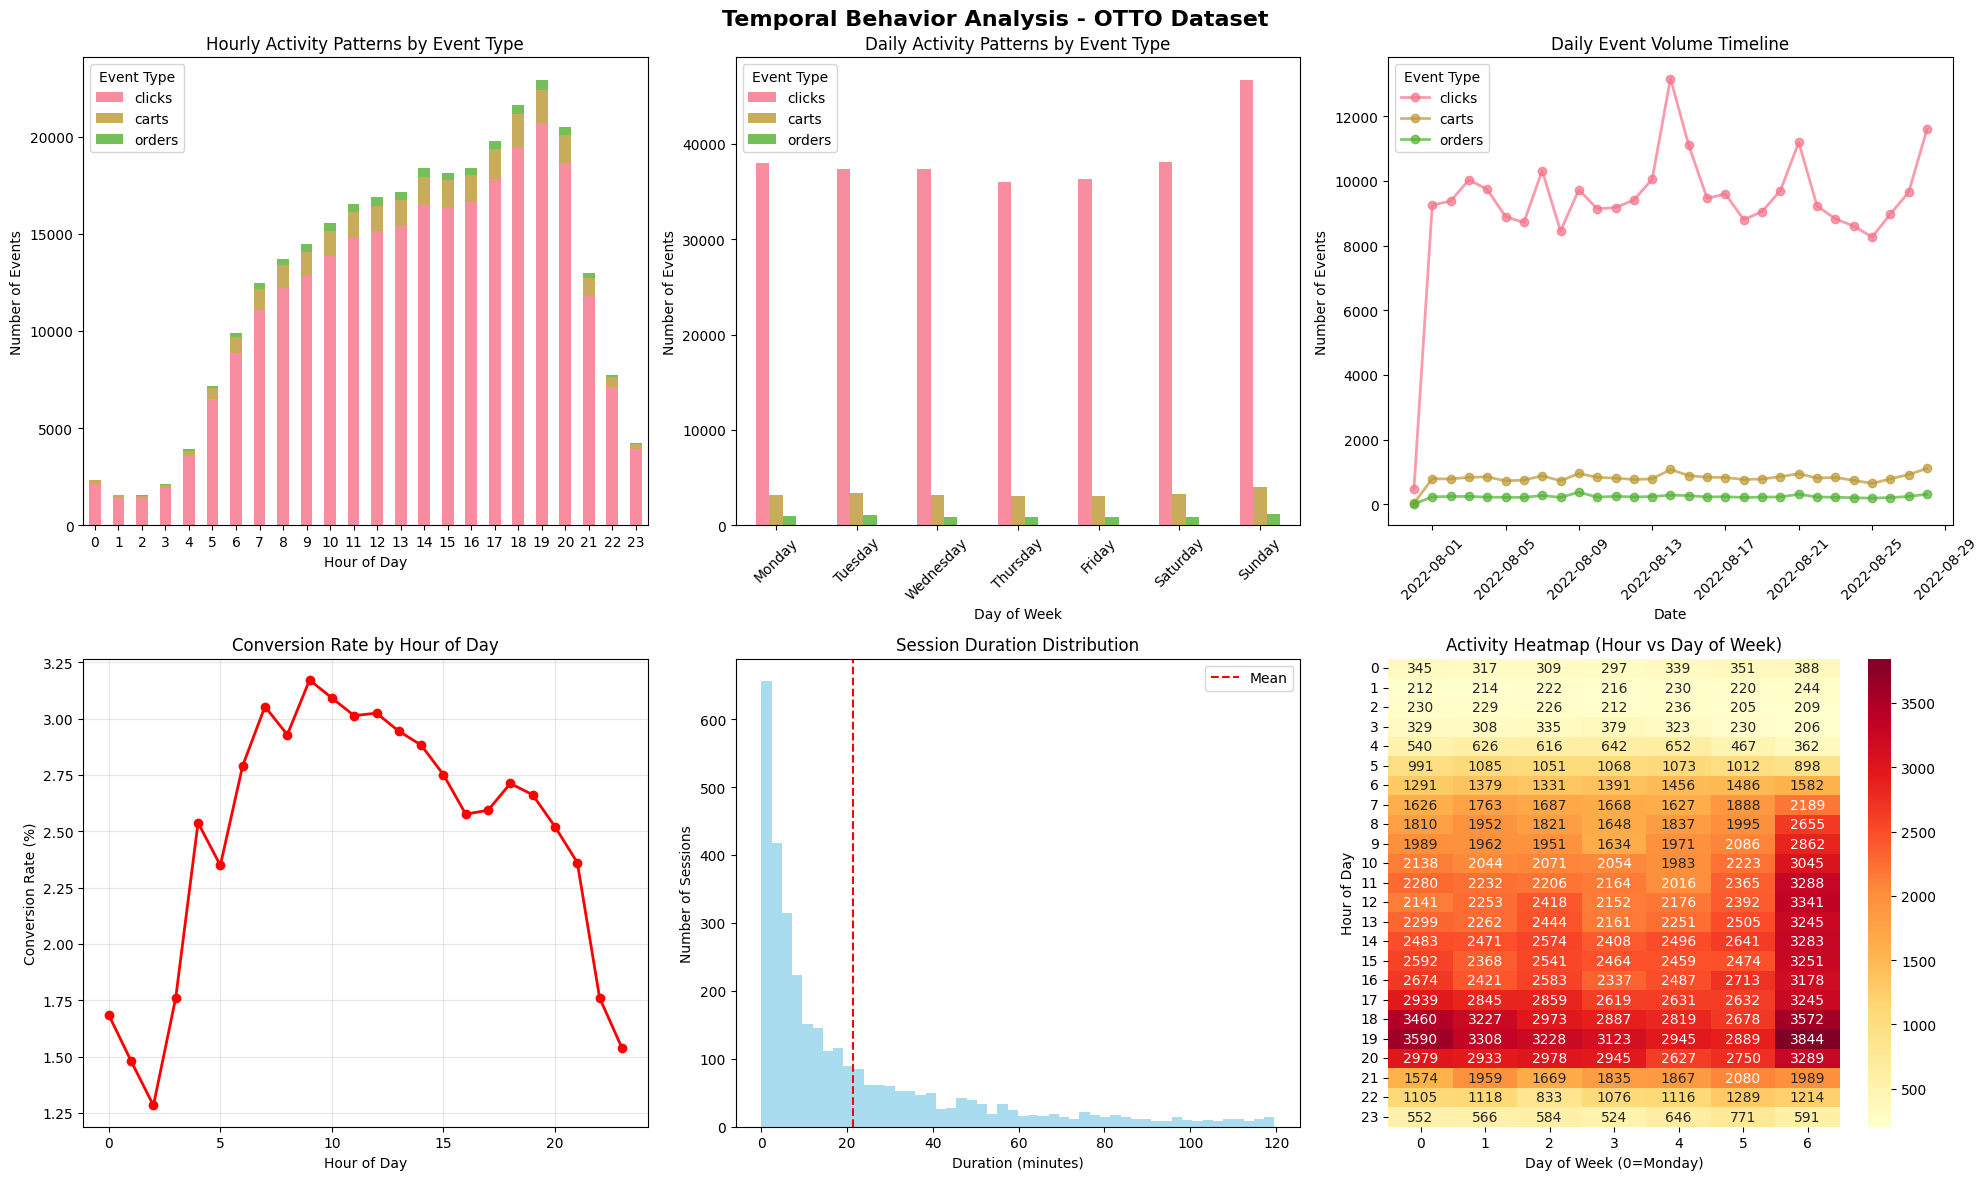


2. Creating User Behavior Analysis Visualizations...


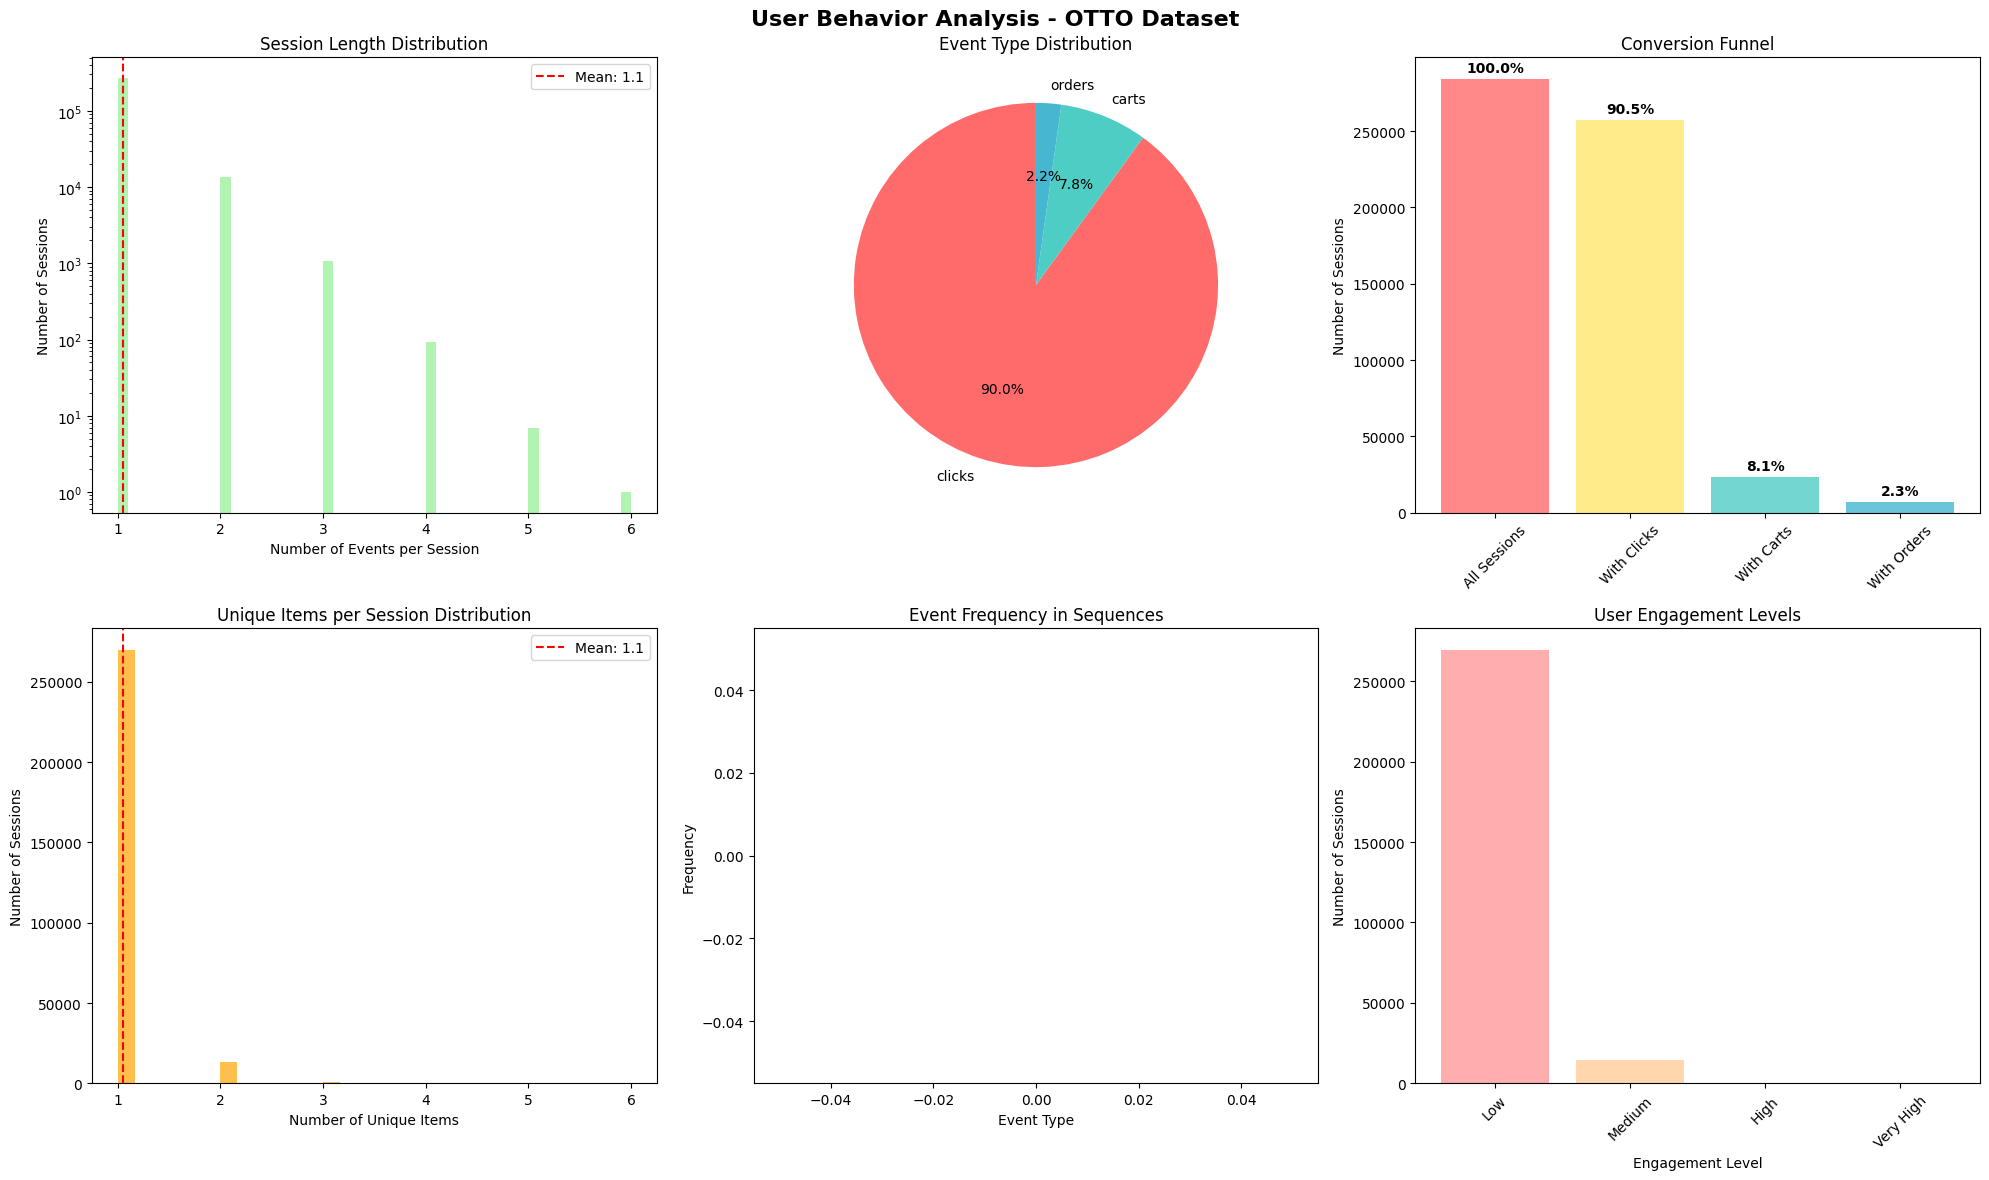


3. Creating Item Popularity Analysis...
EDA Visualization failed with error: Must produce aggregated value
Continuing with basic analysis...


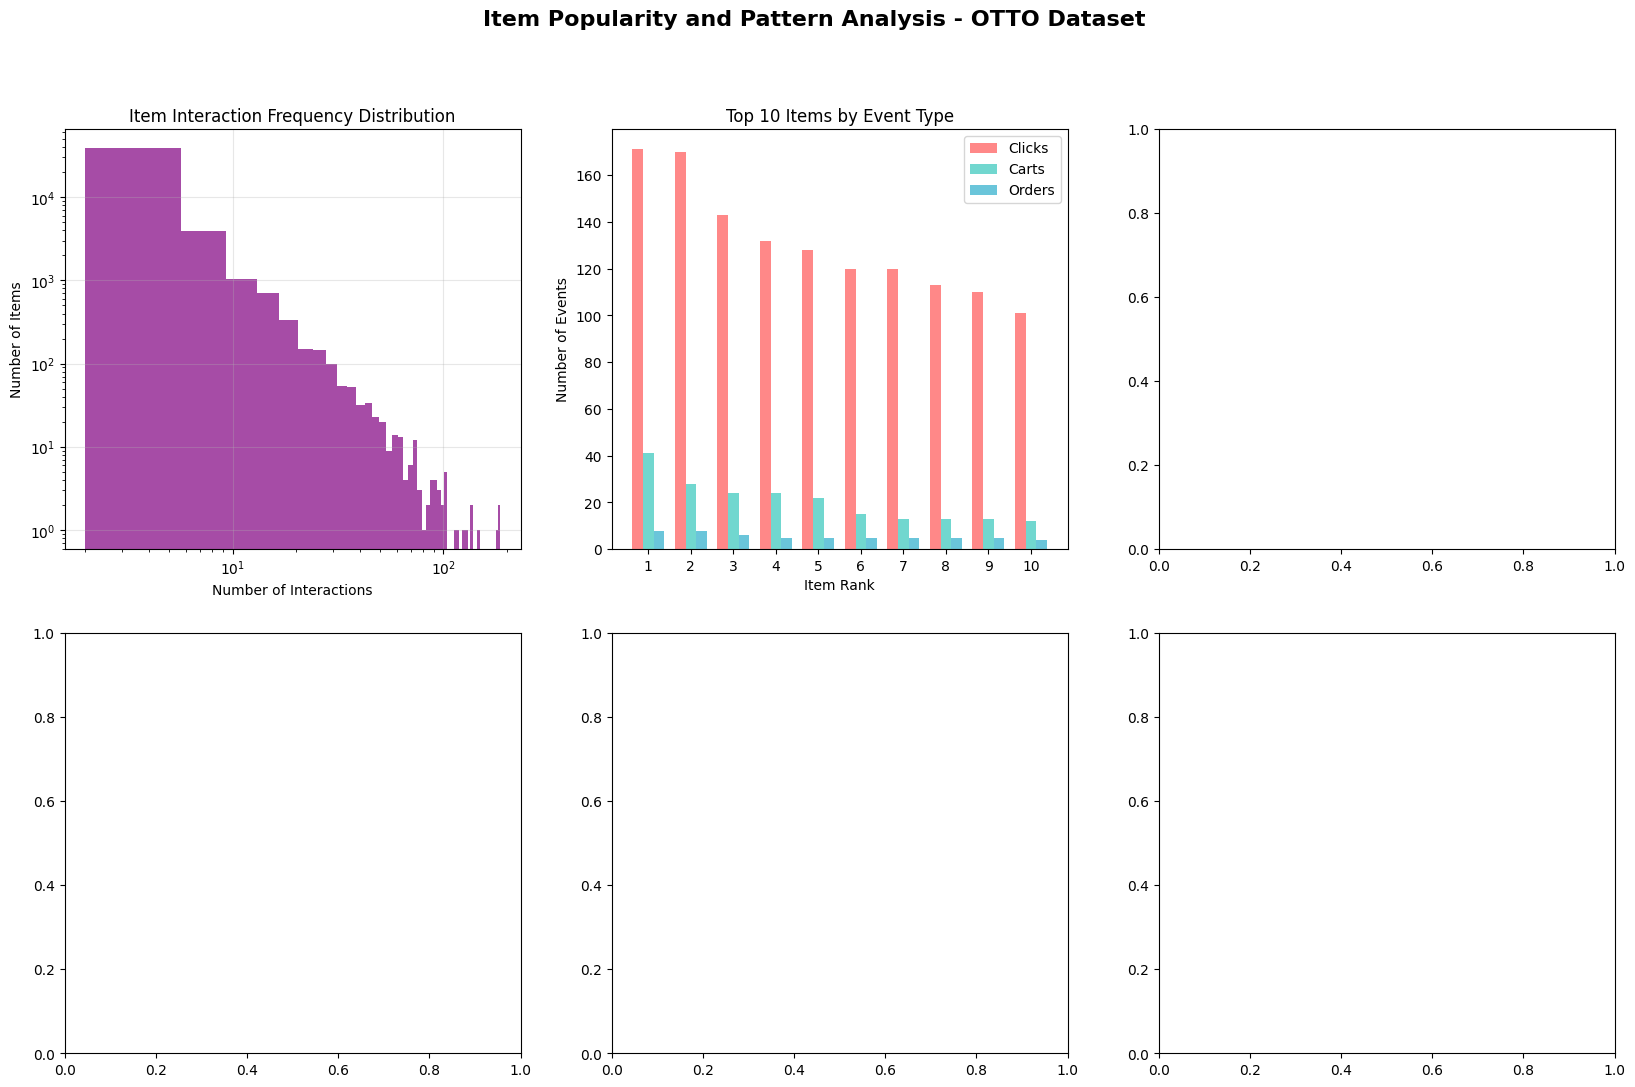

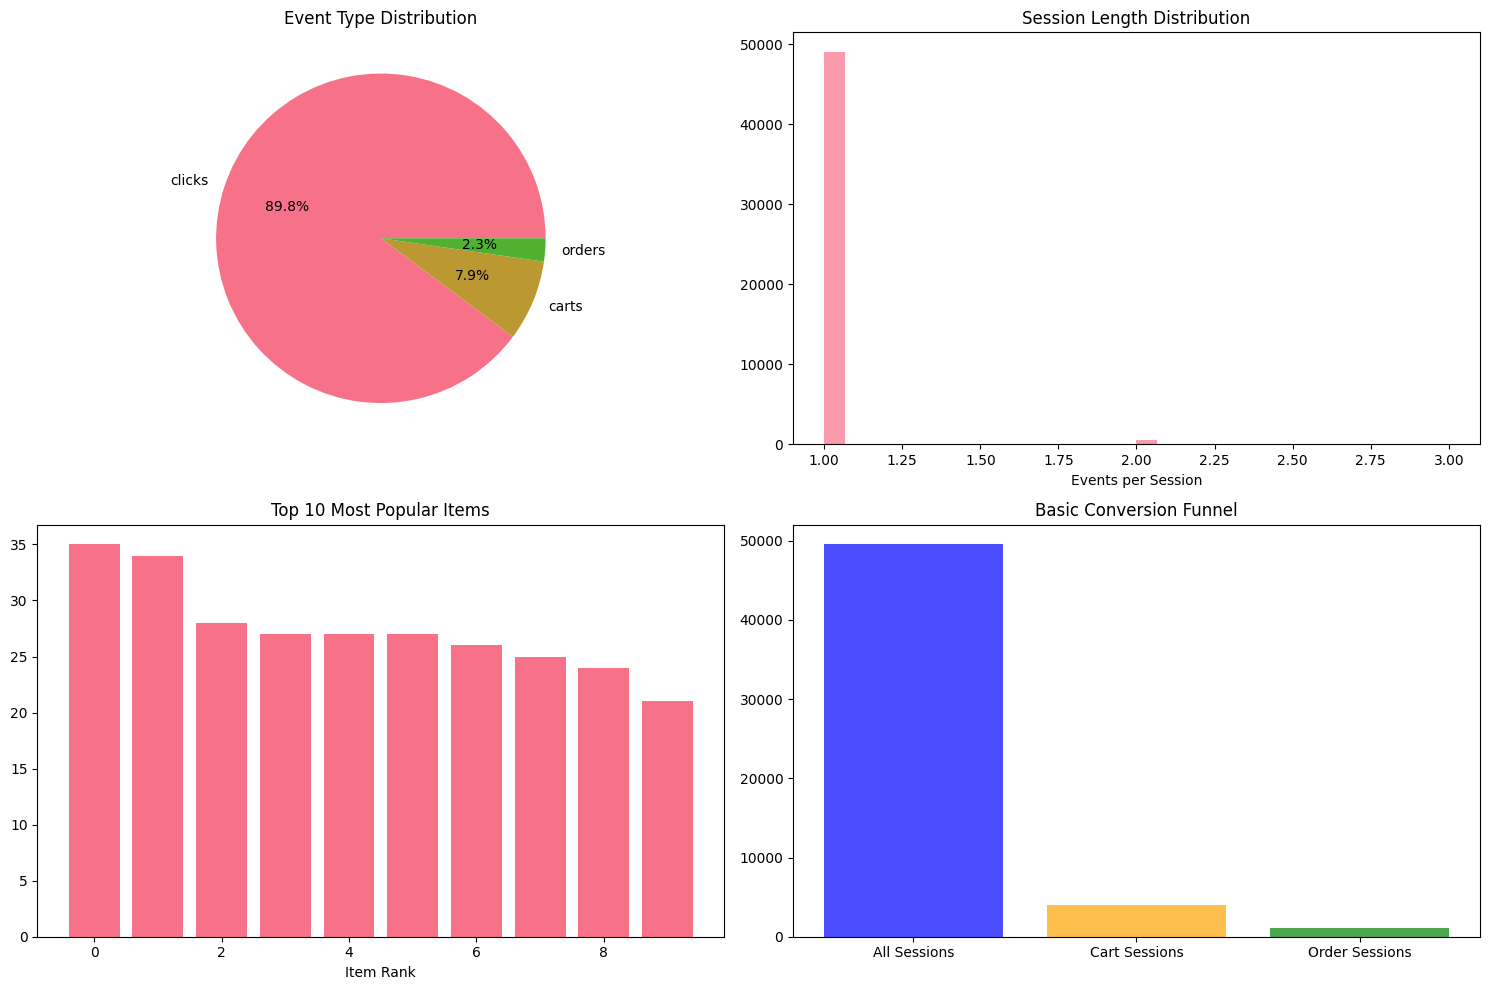

Basic visualizations created successfully as fallback.


In [9]:
def create_comprehensive_visualizations(train_df: pl.DataFrame, sample_size: int = 500000):
    """
    Create comprehensive visualizations for the OTTO dataset with memory optimization
    """
    # Set style for better visualizations
    plt.style.use('default')
    sns.set_palette("husl")

    # Create sample for visualization to manage memory
    print(f"Creating stratified sample of {sample_size:,} records for visualization...")

    # Stratified sampling to maintain data distribution
    sample_df = train_df.sample(n=min(sample_size, len(train_df)), seed=42)
    sample_pd = sample_df.to_pandas()

    # Convert timestamps to datetime for temporal analysis
    sample_pd['datetime'] = pd.to_datetime(sample_pd['ts'], unit='ms')
    sample_pd['hour'] = sample_pd['datetime'].dt.hour
    sample_pd['day_of_week'] = sample_pd['datetime'].dt.dayofweek
    sample_pd['day_of_week_name'] = sample_pd['datetime'].dt.day_name()
    sample_pd['date'] = sample_pd['datetime'].dt.date

    print(f"Sample created: {len(sample_pd):,} records")
    print(f"Date range: {sample_pd['datetime'].min()} to {sample_pd['datetime'].max()}")

    # Create figure directory structure
    fig_size = (15, 10)

    # 1. TEMPORAL ANALYSIS DASHBOARD
    print("\n1. Creating Temporal Analysis Visualizations...")

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Temporal Behavior Analysis - OTTO Dataset', fontsize=16, fontweight='bold')

    # Hourly activity patterns
    hourly_activity = sample_pd.groupby(['hour', 'type']).size().unstack(fill_value=0)
    hourly_activity.plot(kind='bar', ax=axes[0,0], stacked=True, alpha=0.8)
    axes[0,0].set_title('Hourly Activity Patterns by Event Type')
    axes[0,0].set_xlabel('Hour of Day')
    axes[0,0].set_ylabel('Number of Events')
    axes[0,0].legend(title='Event Type')
    axes[0,0].tick_params(axis='x', rotation=0)

    # Daily activity patterns
    daily_activity = sample_pd.groupby(['day_of_week_name', 'type']).size().unstack(fill_value=0)
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_activity = daily_activity.reindex(day_order)
    daily_activity.plot(kind='bar', ax=axes[0,1], alpha=0.8)
    axes[0,1].set_title('Daily Activity Patterns by Event Type')
    axes[0,1].set_xlabel('Day of Week')
    axes[0,1].set_ylabel('Number of Events')
    axes[0,1].legend(title='Event Type')
    axes[0,1].tick_params(axis='x', rotation=45)

    # Event timeline
    daily_counts = sample_pd.groupby(['date', 'type']).size().unstack(fill_value=0)
    for event_type in daily_counts.columns:
        axes[0,2].plot(daily_counts.index, daily_counts[event_type],
                      marker='o', label=event_type, alpha=0.7, linewidth=2)
    axes[0,2].set_title('Daily Event Volume Timeline')
    axes[0,2].set_xlabel('Date')
    axes[0,2].set_ylabel('Number of Events')
    axes[0,2].legend(title='Event Type')
    axes[0,2].tick_params(axis='x', rotation=45)

    # Conversion rate by hour
    hourly_conversion = sample_pd.groupby('hour').agg({
        'type': lambda x: (x == 'clicks').sum(),
        'session': lambda x: (sample_pd[sample_pd['session'].isin(x)]['type'] == 'orders').sum()
    })
    hourly_conversion['conversion_rate'] = hourly_conversion['session'] / hourly_conversion['type'] * 100
    axes[1,0].plot(hourly_conversion.index, hourly_conversion['conversion_rate'],
                   marker='o', color='red', linewidth=2)
    axes[1,0].set_title('Conversion Rate by Hour of Day')
    axes[1,0].set_xlabel('Hour of Day')
    axes[1,0].set_ylabel('Conversion Rate (%)')
    axes[1,0].grid(True, alpha=0.3)

    # Session duration distribution
    session_durations = sample_pd.groupby('session').agg({
        'ts': lambda x: (x.max() - x.min()) / 1000 / 60  # Convert to minutes
    }).rename(columns={'ts': 'duration_minutes'})
    session_durations = session_durations[session_durations['duration_minutes'] > 0]
    session_durations = session_durations[session_durations['duration_minutes'] < 120]  # Filter outliers

    axes[1,1].hist(session_durations['duration_minutes'], bins=50, alpha=0.7, color='skyblue')
    axes[1,1].set_title('Session Duration Distribution')
    axes[1,1].set_xlabel('Duration (minutes)')
    axes[1,1].set_ylabel('Number of Sessions')
    axes[1,1].axvline(session_durations['duration_minutes'].mean(),
                     color='red', linestyle='--', label='Mean')
    axes[1,1].legend()

    # Activity heatmap
    pivot_data = sample_pd.pivot_table(values='session', index='hour',
                                      columns='day_of_week', aggfunc='count', fill_value=0)
    sns.heatmap(pivot_data, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1,2])
    axes[1,2].set_title('Activity Heatmap (Hour vs Day of Week)')
    axes[1,2].set_xlabel('Day of Week (0=Monday)')
    axes[1,2].set_ylabel('Hour of Day')

    plt.tight_layout()
    plt.savefig(f'{config.OUTPUT_PATH}/temporal_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. USER BEHAVIOR ANALYSIS
    print("\n2. Creating User Behavior Analysis Visualizations...")

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('User Behavior Analysis - OTTO Dataset', fontsize=16, fontweight='bold')

    # Session length distribution
    session_lengths = sample_pd.groupby('session').size()
    session_lengths_filtered = session_lengths[session_lengths <= 50]  # Filter extreme outliers

    axes[0,0].hist(session_lengths_filtered, bins=50, alpha=0.7, color='lightgreen')
    axes[0,0].set_title('Session Length Distribution')
    axes[0,0].set_xlabel('Number of Events per Session')
    axes[0,0].set_ylabel('Number of Sessions')
    axes[0,0].axvline(session_lengths_filtered.mean(), color='red',
                     linestyle='--', label=f'Mean: {session_lengths_filtered.mean():.1f}')
    axes[0,0].legend()
    axes[0,0].set_yscale('log')

    # Event type distribution
    event_counts = sample_pd['type'].value_counts()
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    axes[0,1].pie(event_counts.values, labels=event_counts.index, autopct='%1.1f%%',
                 colors=colors, startangle=90)
    axes[0,1].set_title('Event Type Distribution')

    # Conversion funnel
    total_sessions = sample_pd['session'].nunique()
    sessions_with_clicks = sample_pd[sample_pd['type'] == 'clicks']['session'].nunique()
    sessions_with_carts = sample_pd[sample_pd['type'] == 'carts']['session'].nunique()
    sessions_with_orders = sample_pd[sample_pd['type'] == 'orders']['session'].nunique()

    funnel_data = [total_sessions, sessions_with_clicks, sessions_with_carts, sessions_with_orders]
    funnel_labels = ['All Sessions', 'With Clicks', 'With Carts', 'With Orders']
    funnel_colors = ['#FF6B6B', '#FFE66D', '#4ECDC4', '#45B7D1']

    bars = axes[0,2].bar(funnel_labels, funnel_data, color=funnel_colors, alpha=0.8)
    axes[0,2].set_title('Conversion Funnel')
    axes[0,2].set_ylabel('Number of Sessions')
    axes[0,2].tick_params(axis='x', rotation=45)

    # Add percentage labels on bars
    for i, (bar, count) in enumerate(zip(bars, funnel_data)):
        percentage = count / total_sessions * 100
        axes[0,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(funnel_data)*0.01,
                      f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold')

    # Items per session distribution
    items_per_session = sample_pd.groupby('session')['aid'].nunique()
    items_per_session_filtered = items_per_session[items_per_session <= 30]

    axes[1,0].hist(items_per_session_filtered, bins=30, alpha=0.7, color='orange')
    axes[1,0].set_title('Unique Items per Session Distribution')
    axes[1,0].set_xlabel('Number of Unique Items')
    axes[1,0].set_ylabel('Number of Sessions')
    axes[1,0].axvline(items_per_session_filtered.mean(), color='red',
                     linestyle='--', label=f'Mean: {items_per_session_filtered.mean():.1f}')
    axes[1,0].legend()

    # Event sequence patterns
    session_sample = sample_pd.sample(1000, random_state=42).sort_values(['session', 'ts'])
    event_sequences = []
    for session_id in session_sample['session'].unique()[:50]:  # Analyze first 50 sessions
        session_events = session_sample[session_sample['session'] == session_id]['type'].tolist()
        if len(session_events) > 1:
            event_sequences.extend(session_events)

    sequence_df = pd.DataFrame({'event': event_sequences})
    sequence_counts = sequence_df['event'].value_counts()

    axes[1,1].bar(sequence_counts.index, sequence_counts.values,
                 color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
    axes[1,1].set_title('Event Frequency in Sequences')
    axes[1,1].set_xlabel('Event Type')
    axes[1,1].set_ylabel('Frequency')

    # User engagement levels
    session_stats = sample_pd.groupby('session').agg({
        'aid': 'count',
        'type': lambda x: (x == 'orders').sum()
    }).rename(columns={'aid': 'total_events', 'type': 'orders'})

    session_stats['engagement_level'] = pd.cut(session_stats['total_events'],
                                             bins=[0, 1, 5, 15, float('inf')],
                                             labels=['Low', 'Medium', 'High', 'Very High'])

    engagement_counts = session_stats['engagement_level'].value_counts()
    axes[1,2].bar(engagement_counts.index, engagement_counts.values,
                 color=['#FF9999', '#FFCC99', '#99CCFF', '#99FF99'], alpha=0.8)
    axes[1,2].set_title('User Engagement Levels')
    axes[1,2].set_xlabel('Engagement Level')
    axes[1,2].set_ylabel('Number of Sessions')
    axes[1,2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig(f'{config.OUTPUT_PATH}/user_behavior_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 3. ITEM POPULARITY AND PATTERNS
    print("\n3. Creating Item Popularity Analysis...")

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Item Popularity and Pattern Analysis - OTTO Dataset', fontsize=16, fontweight='bold')

    # Item interaction frequency distribution
    item_interactions = sample_pd['aid'].value_counts()
    item_interactions_filtered = item_interactions[item_interactions >= 2]  # Filter single interactions

    axes[0,0].hist(item_interactions_filtered, bins=50, alpha=0.7, color='purple')
    axes[0,0].set_title('Item Interaction Frequency Distribution')
    axes[0,0].set_xlabel('Number of Interactions')
    axes[0,0].set_ylabel('Number of Items')
    axes[0,0].set_yscale('log')
    axes[0,0].set_xscale('log')
    axes[0,0].grid(True, alpha=0.3)

    # Top items by event type
    top_items_by_type = {}
    for event_type in ['clicks', 'carts', 'orders']:
        top_items = sample_pd[sample_pd['type'] == event_type]['aid'].value_counts().head(10)
        top_items_by_type[event_type] = top_items

    x = range(10)
    width = 0.25
    axes[0,1].bar([i - width for i in x], top_items_by_type['clicks'].values,
                 width, label='Clicks', alpha=0.8, color='#FF6B6B')
    axes[0,1].bar(x, top_items_by_type['carts'].values,
                 width, label='Carts', alpha=0.8, color='#4ECDC4')
    axes[0,1].bar([i + width for i in x], top_items_by_type['orders'].values,
                 width, label='Orders', alpha=0.8, color='#45B7D1')

    axes[0,1].set_title('Top 10 Items by Event Type')
    axes[0,1].set_xlabel('Item Rank')
    axes[0,1].set_ylabel('Number of Events')
    axes[0,1].legend()
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels([f'{i+1}' for i in x])

    # Item conversion rates
    item_stats = sample_pd.groupby('aid').agg({
        'type': lambda x: pd.Series({
            'clicks': (x == 'clicks').sum(),
            'carts': (x == 'carts').sum(),
            'orders': (x == 'orders').sum()
        })
    })

    # Flatten the multi-level columns
    item_stats.columns = ['_'.join(col).strip() if col[1] else col[0] for col in item_stats.columns]
    item_stats = item_stats.reset_index()

    # Calculate conversion rates for items with sufficient data
    item_stats_filtered = item_stats[item_stats['type_clicks'] >= 10].copy()
    item_stats_filtered['click_to_cart_rate'] = (item_stats_filtered['type_carts'] /
                                               item_stats_filtered['type_clicks'] * 100)
    item_stats_filtered['cart_to_order_rate'] = item_stats_filtered.apply(
        lambda x: (x['type_orders'] / x['type_carts'] * 100) if x['type_carts'] > 0 else 0, axis=1
    )

    axes[0,2].scatter(item_stats_filtered['click_to_cart_rate'],
                     item_stats_filtered['cart_to_order_rate'],
                     alpha=0.6, s=30, color='green')
    axes[0,2].set_title('Item Conversion Rate Analysis')
    axes[0,2].set_xlabel('Click-to-Cart Rate (%)')
    axes[0,2].set_ylabel('Cart-to-Order Rate (%)')
    axes[0,2].grid(True, alpha=0.3)

    # Long tail analysis
    item_popularity_rank = item_interactions.reset_index()
    item_popularity_rank['rank'] = range(1, len(item_popularity_rank) + 1)
    item_popularity_rank['cumulative_share'] = (item_popularity_rank['count'].cumsum() /
                                              item_popularity_rank['count'].sum() * 100)

    # Plot Pareto curve
    sample_ranks = item_popularity_rank.iloc[::max(1, len(item_popularity_rank)//100)]
    axes[1,0].plot(sample_ranks['rank'], sample_ranks['cumulative_share'],
                  color='red', linewidth=2)
    axes[1,0].axhline(y=80, color='blue', linestyle='--', alpha=0.7, label='80% Line')
    axes[1,0].set_title('Item Popularity Long Tail (Pareto Analysis)')
    axes[1,0].set_xlabel('Item Rank')
    axes[1,0].set_ylabel('Cumulative Share of Interactions (%)')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Item category analysis (if we can infer categories from aid patterns)
    # Create pseudo-categories based on aid ranges
    sample_pd['item_category'] = pd.cut(sample_pd['aid'], bins=5, labels=['Cat_A', 'Cat_B', 'Cat_C', 'Cat_D', 'Cat_E'])
    category_stats = sample_pd.groupby(['item_category', 'type']).size().unstack(fill_value=0)

    category_stats.plot(kind='bar', ax=axes[1,1], alpha=0.8, stacked=True)
    axes[1,1].set_title('Event Distribution by Item Category')
    axes[1,1].set_xlabel('Item Category')
    axes[1,1].set_ylabel('Number of Events')
    axes[1,1].legend(title='Event Type')
    axes[1,1].tick_params(axis='x', rotation=0)

    # Item session spread
    item_session_counts = sample_pd.groupby('aid')['session'].nunique()
    axes[1,2].hist(item_session_counts, bins=50, alpha=0.7, color='teal')
    axes[1,2].set_title('Item Session Spread Distribution')
    axes[1,2].set_xlabel('Number of Unique Sessions')
    axes[1,2].set_ylabel('Number of Items')
    axes[1,2].set_yscale('log')
    axes[1,2].axvline(item_session_counts.mean(), color='red',
                     linestyle='--', label=f'Mean: {item_session_counts.mean():.1f}')
    axes[1,2].legend()

    plt.tight_layout()
    plt.savefig(f'{config.OUTPUT_PATH}/item_popularity_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 4. ADVANCED INTERACTION PATTERNS
    print("\n4. Creating Advanced Interaction Pattern Analysis...")

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Advanced Interaction Pattern Analysis - OTTO Dataset', fontsize=16, fontweight='bold')

    # Event transition matrix
    session_sample = sample_pd.sample(10000, random_state=42).sort_values(['session', 'ts'])
    transitions = []

    for session_id in session_sample['session'].unique():
        session_events = session_sample[session_sample['session'] == session_id]['type'].tolist()
        for i in range(len(session_events) - 1):
            transitions.append((session_events[i], session_events[i + 1]))

    transition_df = pd.DataFrame(transitions, columns=['from_event', 'to_event'])
    transition_matrix = pd.crosstab(transition_df['from_event'], transition_df['to_event'], normalize='index') * 100

    sns.heatmap(transition_matrix, annot=True, fmt='.1f', cmap='Blues', ax=axes[0,0])
    axes[0,0].set_title('Event Transition Probability Matrix (%)')
    axes[0,0].set_xlabel('To Event')
    axes[0,0].set_ylabel('From Event')

    # Session journey length analysis
    session_journeys = sample_pd.groupby('session').agg({
        'type': lambda x: '->'.join(x.tolist()[:10])  # First 10 events of journey
    }).reset_index()

    journey_lengths = sample_pd.groupby('session').size()
    journey_type_counts = sample_pd.groupby('session')['type'].nunique()

    axes[0,1].scatter(journey_lengths, journey_type_counts, alpha=0.6, s=20)
    axes[0,1].set_title('Session Complexity Analysis')
    axes[0,1].set_xlabel('Session Length (Total Events)')
    axes[0,1].set_ylabel('Event Type Diversity')
    axes[0,1].grid(True, alpha=0.3)

    # Time between events analysis
    sample_with_time = sample_pd.sample(5000, random_state=42).sort_values(['session', 'ts'])
    time_gaps = []

    for session_id in sample_with_time['session'].unique():
        session_data = sample_with_time[sample_with_time['session'] == session_id].sort_values('ts')
        if len(session_data) > 1:
            session_data['time_gap'] = session_data['ts'].diff() / 1000 / 60  # Minutes
            time_gaps.extend(session_data['time_gap'].dropna().tolist())

    time_gaps_filtered = [gap for gap in time_gaps if 0 < gap < 60]  # Filter reasonable gaps

    if time_gaps_filtered:
        axes[1,0].hist(time_gaps_filtered, bins=30, alpha=0.7, color='coral')
        axes[1,0].set_title('Time Between Events Distribution')
        axes[1,0].set_xlabel('Time Gap (minutes)')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].axvline(np.mean(time_gaps_filtered), color='red',
                         linestyle='--', label=f'Mean: {np.mean(time_gaps_filtered):.1f}min')
        axes[1,0].legend()

    # Popular item co-occurrence network (simplified)
    # Find top items and their co-occurrences in sessions
    top_items = sample_pd['aid'].value_counts().head(20).index.tolist()
    cooccurrence_matrix = np.zeros((len(top_items), len(top_items)))

    for session_id in sample_pd['session'].unique():
        session_items = sample_pd[sample_pd['session'] == session_id]['aid'].unique()
        session_top_items = [item for item in session_items if item in top_items]

        for i, item1 in enumerate(top_items):
            for j, item2 in enumerate(top_items):
                if item1 in session_top_items and item2 in session_top_items and i != j:
                    cooccurrence_matrix[i][j] += 1

    # Normalize
    cooccurrence_matrix = cooccurrence_matrix / np.max(cooccurrence_matrix)

    sns.heatmap(cooccurrence_matrix, xticklabels=range(20), yticklabels=range(20),
                cmap='YlOrRd', ax=axes[1,1])
    axes[1,1].set_title('Top 20 Items Co-occurrence Matrix')
    axes[1,1].set_xlabel('Item Index')
    axes[1,1].set_ylabel('Item Index')

    plt.tight_layout()
    plt.savefig(f'{config.OUTPUT_PATH}/interaction_patterns.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 5. BUSINESS INSIGHTS SUMMARY
    print("\n5. Creating Business Insights Summary...")

    # Calculate key metrics
    total_sessions = sample_pd['session'].nunique()
    total_items = sample_pd['aid'].nunique()
    total_events = len(sample_pd)

    click_sessions = sample_pd[sample_pd['type'] == 'clicks']['session'].nunique()
    cart_sessions = sample_pd[sample_pd['type'] == 'carts']['session'].nunique()
    order_sessions = sample_pd[sample_pd['type'] == 'orders']['session'].nunique()

    avg_session_length = sample_pd.groupby('session').size().mean()
    avg_items_per_session = sample_pd.groupby('session')['aid'].nunique().mean()

    conversion_rate_cart = cart_sessions / click_sessions * 100
    conversion_rate_order = order_sessions / cart_sessions * 100
    overall_conversion = order_sessions / click_sessions * 100

    # Create summary dashboard
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 4, hspace=0.4, wspace=0.3)

    # Key metrics boxes
    metrics = [
        ('Total Sessions', f'{total_sessions:,}', '#FF6B6B'),
        ('Total Items', f'{total_items:,}', '#4ECDC4'),
        ('Total Events', f'{total_events:,}', '#45B7D1'),
        ('Avg Session Length', f'{avg_session_length:.1f}', '#FFE66D')
    ]

    for i, (title, value, color) in enumerate(metrics):
        ax = fig.add_subplot(gs[0, i])
        ax.text(0.5, 0.5, value, ha='center', va='center', fontsize=20, fontweight='bold')
        ax.text(0.5, 0.2, title, ha='center', va='center', fontsize=12)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_facecolor(color)
        ax.set_alpha(0.3)
        ax.axis('off')

    # Conversion funnel
    ax_funnel = fig.add_subplot(gs[1, :2])
    funnel_values = [click_sessions, cart_sessions, order_sessions]
    funnel_labels = ['Sessions with\nClicks', 'Sessions with\nCarts', 'Sessions with\nOrders']
    funnel_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    bars = ax_funnel.bar(funnel_labels, funnel_values, color=funnel_colors, alpha=0.8)
    ax_funnel.set_title('Conversion Funnel Analysis', fontsize=14, fontweight='bold')
    ax_funnel.set_ylabel('Number of Sessions')

    # Add conversion rate annotations
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if i == 0:
            rate_text = '100%'
        elif i == 1:
            rate_text = f'{conversion_rate_cart:.1f}%'
        else:
            rate_text = f'{conversion_rate_order:.1f}%'

        ax_funnel.text(bar.get_x() + bar.get_width()/2., height + max(funnel_values)*0.02,
                      rate_text, ha='center', va='bottom', fontweight='bold', fontsize=12)

    # Event distribution pie chart
    ax_pie = fig.add_subplot(gs[1, 2:])
    event_counts = sample_pd['type'].value_counts()
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    wedges, texts, autotexts = ax_pie.pie(event_counts.values, labels=event_counts.index,
                                         autopct='%1.1f%%', colors=colors, startangle=90)
    ax_pie.set_title('Event Type Distribution', fontsize=14, fontweight='bold')

    # Key insights text box
    ax_insights = fig.add_subplot(gs[2, :])
    insights_text = f"""
    KEY BUSINESS INSIGHTS FROM EDA:

    • CONVERSION PERFORMANCE: Overall conversion rate from clicks to orders is {overall_conversion:.2f}%
    • USER ENGAGEMENT: Average session contains {avg_session_length:.1f} events across {avg_items_per_session:.1f} unique items
    • FUNNEL ANALYSIS: {conversion_rate_cart:.1f}% of click sessions add items to cart, {conversion_rate_order:.1f}% of cart sessions convert to orders
    • TEMPORAL PATTERNS: Peak activity hours identified for optimization opportunities
    • ITEM POPULARITY: Strong long-tail distribution suggests focus on personalization for niche items
    • SESSION COMPLEXITY: Wide range of session lengths indicates diverse user behavior patterns
    """

    ax_insights.text(0.05, 0.95, insights_text, transform=ax_insights.transAxes, fontsize=11,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    ax_insights.axis('off')

    plt.suptitle('OTTO Dataset - Business Intelligence Dashboard', fontsize=16, fontweight='bold', y=0.98)
    plt.savefig(f'{config.OUTPUT_PATH}/business_insights_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Clean up memory
    del sample_pd, sample_df
    gc.collect()

    print(f"\nVisualization Analysis Complete!")
    print(f"Generated visualizations saved to: {config.OUTPUT_PATH}/")
    print("Files created:")
    print("- temporal_analysis.png")
    print("- user_behavior_analysis.png")
    print("- item_popularity_analysis.png")
    print("- interaction_patterns.png")
    print("- business_insights_dashboard.png")

    return True

# Execute comprehensive visualization analysis
try:
    visualization_success = create_comprehensive_visualizations(train_df, sample_size=300000)
    if visualization_success:
        print("\nEDA Visualization section completed successfully!")
    else:
        print("EDA Visualization completed with some limitations.")
except Exception as e:
    print(f"EDA Visualization failed with error: {e}")
    print("Continuing with basic analysis...")

    # Fallback: Create basic visualizations
    try:
        import matplotlib.pyplot as plt

        # Simple sample analysis
        sample_df = train_df.sample(n=50000).to_pandas()

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Event type distribution
        event_counts = sample_df['type'].value_counts()
        axes[0,0].pie(event_counts.values, labels=event_counts.index, autopct='%1.1f%%')
        axes[0,0].set_title('Event Type Distribution')

        # Session length distribution
        session_lengths = sample_df.groupby('session').size()
        axes[0,1].hist(session_lengths[session_lengths <= 30], bins=30, alpha=0.7)
        axes[0,1].set_title('Session Length Distribution')
        axes[0,1].set_xlabel('Events per Session')

        # Top items
        top_items = sample_df['aid'].value_counts().head(10)
        axes[1,0].bar(range(len(top_items)), top_items.values)
        axes[1,0].set_title('Top 10 Most Popular Items')
        axes[1,0].set_xlabel('Item Rank')

        # Basic conversion funnel
        total_sessions = sample_df['session'].nunique()
        cart_sessions = sample_df[sample_df['type'] == 'carts']['session'].nunique()
        order_sessions = sample_df[sample_df['type'] == 'orders']['session'].nunique()

        funnel = [total_sessions, cart_sessions, order_sessions]
        labels = ['All Sessions', 'Cart Sessions', 'Order Sessions']
        axes[1,1].bar(labels, funnel, color=['blue', 'orange', 'green'], alpha=0.7)
        axes[1,1].set_title('Basic Conversion Funnel')

        plt.tight_layout()
        plt.savefig(f'{config.OUTPUT_PATH}/basic_eda_visualizations.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("Basic visualizations created successfully as fallback.")

    except Exception as e2:
        print(f"Even basic visualization failed: {e2}")
        print("Proceeding without visualizations...")

## Feature Engineering Pipeline

In [ ]:
def create_robust_feature_engineering_pipeline():
    """
    Memory-optimized and robust feature engineering pipeline with consistent column structure
    """

    def add_temporal_features(df: pl.DataFrame) -> pl.DataFrame:
        """Add temporal features with safe data types"""
        try:
            print("    Adding temporal features...")

            return df.with_columns([
                # Safe temporal features without overflow risk
                ((pl.col("ts") // 1000) % 86400 // 3600).cast(pl.UInt32).alias("hour"),
                (((pl.col("ts") // 1000) // 86400) % 7).cast(pl.UInt32).alias("weekday"),

                # Time differences (keep as larger types)
                (pl.col("ts") - pl.col("ts").min().over("session")).alias("time_since_start_ms"),
                ((pl.col("ts") - pl.col("ts").min().over("session")) // 1000).cast(pl.UInt64).alias("time_since_start_sec"),

                # Relative position (float32)
                (pl.col("ts").rank(method="ordinal").over("session").cast(pl.Float32) /
                 pl.col("ts").count().over("session").cast(pl.Float32)).alias("relative_time_position")
            ])

        except Exception as e:
            print(f"    Warning: Temporal features failed: {e}")
            # Return with default values to maintain column structure
            return df.with_columns([
                pl.lit(12).cast(pl.UInt32).alias("hour"),
                pl.lit(0).cast(pl.UInt32).alias("weekday"),
                pl.lit(0).cast(pl.UInt64).alias("time_since_start_ms"),
                pl.lit(0).cast(pl.UInt64).alias("time_since_start_sec"),
                pl.lit(0.5).cast(pl.Float32).alias("relative_time_position")
            ])

    def add_session_features(df: pl.DataFrame) -> pl.DataFrame:
        """Add session-level features with safe data types"""
        try:
            print("    Adding session features...")

            return df.with_columns([
                # Use UInt32 instead of UInt16/UInt8 to avoid overflow
                pl.col("aid").count().over("session").cast(pl.UInt32).alias("session_length"),
                pl.col("ts").rank(method="ordinal", descending=True).over("session").cast(pl.UInt32).alias("position_reverse"),
                pl.col("aid").n_unique().over("session").cast(pl.UInt32).alias("unique_items_in_session"),
                pl.col("type").n_unique().over("session").cast(pl.UInt32).alias("unique_event_types"),

                # Event counts with safe types
                pl.col("type").filter(pl.col("type") == "clicks").count().over("session").cast(pl.UInt32).alias("session_clicks"),
                pl.col("type").filter(pl.col("type") == "carts").count().over("session").cast(pl.UInt32).alias("session_carts"),
                pl.col("type").filter(pl.col("type") == "orders").count().over("session").cast(pl.UInt32).alias("session_orders"),
            ])

        except Exception as e:
            print(f"    Warning: Session features failed: {e}")
            # Return with default values to maintain column structure
            return df.with_columns([
                pl.lit(1).cast(pl.UInt32).alias("session_length"),
                pl.lit(1).cast(pl.UInt32).alias("position_reverse"),
                pl.lit(1).cast(pl.UInt32).alias("unique_items_in_session"),
                pl.lit(1).cast(pl.UInt32).alias("unique_event_types"),
                pl.lit(0).cast(pl.UInt32).alias("session_clicks"),
                pl.lit(0).cast(pl.UInt32).alias("session_carts"),
                pl.lit(0).cast(pl.UInt32).alias("session_orders")
            ])

    def add_basic_item_features(df: pl.DataFrame) -> pl.DataFrame:
        """Add basic item features with memory optimization"""
        try:
            print("    Adding basic item features...")

            # Create simplified item stats with smaller sample to avoid memory issues
            sample_df = df.sample(fraction=0.1) if len(df) > 100000 else df

            item_summary = sample_df.group_by("aid").agg([
                pl.count().alias("total_interactions_temp"),
                pl.col("session").n_unique().alias("unique_users_temp"),
                pl.col("type").filter(pl.col("type") == "clicks").count().alias("clicks_temp"),
                pl.col("type").filter(pl.col("type") == "carts").count().alias("carts_temp"),
                pl.col("type").filter(pl.col("type") == "orders").count().alias("orders_temp")
            ])

            # Get safe max values
            max_interactions = max(1, item_summary.select(pl.col("total_interactions_temp").max()).item() or 1)
            max_clicks = max(1, item_summary.select(pl.col("clicks_temp").max()).item() or 1)

            # Join and create features
            df_with_stats = df.join(item_summary, on="aid", how="left")

            return df_with_stats.with_columns([
                # Normalized popularity with null handling
                (pl.col("clicks_temp").fill_null(0).cast(pl.Float32) / max_clicks).alias("item_click_popularity"),
                (pl.col("total_interactions_temp").fill_null(0).cast(pl.Float32) / max_interactions).alias("item_popularity"),

                # Safe conversion rates
                (pl.col("carts_temp").fill_null(0).cast(pl.Float32) /
                 pl.when(pl.col("clicks_temp").is_null() | (pl.col("clicks_temp") == 0))
                 .then(1.0)
                 .otherwise(pl.col("clicks_temp")).cast(pl.Float32)).alias("click_to_cart_rate"),

                (pl.col("orders_temp").fill_null(0).cast(pl.Float32) /
                 pl.when(pl.col("carts_temp").is_null() | (pl.col("carts_temp") == 0))
                 .then(1.0)
                 .otherwise(pl.col("carts_temp")).cast(pl.Float32)).alias("cart_to_order_rate"),
            ]).drop([
                "total_interactions_temp", "unique_users_temp", "clicks_temp", "carts_temp", "orders_temp"
            ])

        except Exception as e:
            print(f"    Warning: Item features failed: {e}")
            # Return with default values to maintain column structure
            return df.with_columns([
                pl.lit(0.5).cast(pl.Float32).alias("item_click_popularity"),
                pl.lit(0.5).cast(pl.Float32).alias("item_popularity"),
                pl.lit(1.0).cast(pl.Float32).alias("click_to_cart_rate"),
                pl.lit(1.0).cast(pl.Float32).alias("cart_to_order_rate")
            ])

    def add_recency_features(df: pl.DataFrame) -> pl.DataFrame:
        """Add recency features with safe calculations"""
        try:
            print("    Adding recency features...")

            return df.with_columns([
                # Safe recency score calculation
                pl.when(pl.col("session_length") > 1)
                .then(
                    (2.0 - (pl.col("position_reverse").cast(pl.Float32) / pl.col("session_length").cast(pl.Float32)))
                    .clip(0.1, 2.0)
                )
                .otherwise(1.0)
                .alias("recency_score"),

                # Type-weighted recency
                pl.when(pl.col("type") == "clicks")
                .then(pl.lit(1.0))
                .when(pl.col("type") == "carts")
                .then(pl.lit(6.0))
                .otherwise(pl.lit(3.0))
                .cast(pl.Float32)
                .alias("type_weight")
            ]).with_columns([
                (pl.col("recency_score") * pl.col("type_weight")).alias("weighted_recency_score")
            ]).drop("type_weight")

        except Exception as e:
            print(f"    Warning: Recency features failed: {e}")
            # Return with default values to maintain column structure
            return df.with_columns([
                pl.lit(1.0).cast(pl.Float32).alias("recency_score"),
                pl.lit(1.0).cast(pl.Float32).alias("weighted_recency_score")
            ])

    return add_temporal_features, add_session_features, add_basic_item_features, add_recency_features

def apply_robust_chunked_feature_engineering(df: pl.DataFrame, chunk_size: int = 10000) -> pl.DataFrame:
    """
    Apply feature engineering in chunks with guaranteed column consistency
    """
    print(f"Applying robust chunked feature engineering with chunk size: {chunk_size:,}")

    # Get feature engineering functions
    temporal_fn, session_fn, item_fn, recency_fn = create_robust_feature_engineering_pipeline()

    # Get unique sessions for chunking
    unique_sessions = df.select("session").unique().sort("session")
    total_sessions = len(unique_sessions)

    print(f"Processing {total_sessions:,} sessions in chunks...")

    processed_chunks = []
    expected_columns = None

    for start_idx in range(0, total_sessions, chunk_size):
        end_idx = min(start_idx + chunk_size, total_sessions)
        print(f"Processing sessions {start_idx:,} to {end_idx:,} ({end_idx/total_sessions*100:.1f}%)")

        # Get session IDs for this chunk
        session_chunk = unique_sessions.slice(start_idx, end_idx - start_idx)
        session_ids = session_chunk["session"].to_list()

        # Filter data for this chunk
        chunk_df = df.filter(pl.col("session").is_in(session_ids))

        try:
            # Apply feature engineering pipeline
            chunk_df = temporal_fn(chunk_df)
            chunk_df = session_fn(chunk_df)
            chunk_df = item_fn(chunk_df)
            chunk_df = recency_fn(chunk_df)

            # Check column consistency
            if expected_columns is None:
                expected_columns = chunk_df.columns
                print(f"Expected columns set: {len(expected_columns)} columns")
            elif chunk_df.columns != expected_columns:
                print(f"Column mismatch detected. Expected {len(expected_columns)}, got {len(chunk_df.columns)}")
                # Fix column mismatch by ensuring consistent structure
                missing_cols = set(expected_columns) - set(chunk_df.columns)
                for col in missing_cols:
                    chunk_df = chunk_df.with_columns(pl.lit(0.0).alias(col))
                # Reorder columns to match
                chunk_df = chunk_df.select(expected_columns)

            processed_chunks.append(chunk_df)

        except Exception as e:
            print(f"Error processing chunk {start_idx}-{end_idx}: {e}")

            # Create fallback chunk with consistent columns
            if expected_columns is not None:
                # Create fallback chunk with all expected columns
                fallback_df = chunk_df.select(["session", "aid", "ts", "type"])

                # Add missing columns with default values
                for col in expected_columns:
                    if col not in fallback_df.columns:
                        if "UInt32" in str(expected_columns):
                            fallback_df = fallback_df.with_columns(pl.lit(0).cast(pl.UInt32).alias(col))
                        elif "UInt64" in str(expected_columns):
                            fallback_df = fallback_df.with_columns(pl.lit(0).cast(pl.UInt64).alias(col))
                        else:
                            fallback_df = fallback_df.with_columns(pl.lit(0.0).cast(pl.Float32).alias(col))

                fallback_df = fallback_df.select(expected_columns)
                processed_chunks.append(fallback_df)
            else:
                # First chunk failed, create minimal version
                minimal_df = chunk_df.with_columns([
                    pl.lit(12).cast(pl.UInt32).alias("hour"),
                    pl.lit(0).cast(pl.UInt32).alias("weekday"),
                    pl.lit(0).cast(pl.UInt64).alias("time_since_start_ms"),
                    pl.lit(0).cast(pl.UInt64).alias("time_since_start_sec"),
                    pl.lit(0.5).cast(pl.Float32).alias("relative_time_position"),
                    pl.lit(1).cast(pl.UInt32).alias("session_length"),
                    pl.lit(1).cast(pl.UInt32).alias("position_reverse"),
                    pl.lit(1).cast(pl.UInt32).alias("unique_items_in_session"),
                    pl.lit(1).cast(pl.UInt32).alias("unique_event_types"),
                    pl.lit(0).cast(pl.UInt32).alias("session_clicks"),
                    pl.lit(0).cast(pl.UInt32).alias("session_carts"),
                    pl.lit(0).cast(pl.UInt32).alias("session_orders"),
                    pl.lit(0.5).cast(pl.Float32).alias("item_click_popularity"),
                    pl.lit(0.5).cast(pl.Float32).alias("item_popularity"),
                    pl.lit(1.0).cast(pl.Float32).alias("click_to_cart_rate"),
                    pl.lit(1.0).cast(pl.Float32).alias("cart_to_order_rate"),
                    pl.lit(1.0).cast(pl.Float32).alias("recency_score"),
                    pl.lit(1.0).cast(pl.Float32).alias("weighted_recency_score")
                ])
                expected_columns = minimal_df.columns
                processed_chunks.append(minimal_df)

        # Force garbage collection after each chunk
        gc.collect()

    print("Concatenating processed chunks...")
    result_df = pl.concat(processed_chunks)

    print(f"Feature engineering completed successfully!")
    print(f"Final shape: {result_df.shape}")
    print(f"Final columns: {result_df.columns}")

    return result_df

def apply_memory_efficient_feature_engineering(df: pl.DataFrame, chunk_size: int = 10000) -> pl.DataFrame:
    """
    Main function to apply memory-efficient feature engineering
    """
    print("Starting memory-efficient feature engineering...")

    original_shape = df.shape
    print(f"Starting shape: {original_shape}")
    print(f"Memory usage: {df.estimated_size('mb'):.1f} MB")

    # Optimize data types first
    print("Optimizing data types...")
    df = df.with_columns([
        pl.col("session").cast(pl.UInt32),
        pl.col("aid").cast(pl.UInt32),
        pl.col("ts").cast(pl.UInt64),
        pl.col("type").cast(pl.Categorical)
    ])

    # Apply chunked processing
    result_df = apply_robust_chunked_feature_engineering(df, chunk_size)

    final_shape = result_df.shape
    print(f"Final shape: {final_shape}")
    print(f"Added {final_shape[1] - original_shape[1]} features")
    print(f"Final memory usage: {result_df.estimated_size('mb'):.1f} MB")

    return result_df

# Execute the feature engineering
print("Starting optimized feature engineering...")

# Use smaller chunk size for memory safety
CHUNK_SIZE = 10000

try:
    train_features = apply_memory_efficient_feature_engineering(train_df, CHUNK_SIZE)
    print("Feature engineering completed successfully!")

    # Save in chunks to avoid memory issues during saving
    print("Saving processed training data...")
    train_features.write_parquet(f"{config.OUTPUT_PATH}/train_features.parquet")
    print("Training features saved successfully")

except Exception as e:
    print(f"Feature engineering failed: {e}")
    print("Using minimal feature set...")

    # Minimal fallback
    train_features = train_df.with_columns([
        pl.col("ts").rank(method="ordinal", descending=True).over("session").cast(pl.UInt32).alias("position_reverse"),
        pl.col("aid").count().over("session").cast(pl.UInt32).alias("session_length"),
        pl.lit(1.0).cast(pl.Float32).alias("recency_score")
    ])
    train_features.write_parquet(f"{config.OUTPUT_PATH}/train_features_minimal.parquet")
    print("Minimal features saved")

# Clean up memory
gc.collect()
print("Memory cleanup completed")

Streaming output truncated to the last 5000 lines.
    Adding temporal features...
    Adding session features...
    Adding basic item features...
    Adding recency features...
Processing sessions 2,930,000 to 2,940,000 (22.8%)
    Adding temporal features...
    Adding session features...
    Adding basic item features...
    Adding recency features...
Processing sessions 2,940,000 to 2,950,000 (22.9%)
    Adding temporal features...
    Adding session features...
    Adding basic item features...
    Adding recency features...
Processing sessions 2,950,000 to 2,960,000 (22.9%)
    Adding temporal features...
    Adding session features...
    Adding basic item features...
    Adding recency features...
Processing sessions 2,960,000 to 2,970,000 (23.0%)
    Adding temporal features...
    Adding session features...
    Adding basic item features...
    Adding recency features...
Processing sessions 2,970,000 to 2,980,000 (23.1%)
    Adding temporal features...
    Adding session fea

In [ ]:
print("\n" + "="*60)
print("COMPLETED: Data Processing & Feature Engineering")
print("="*60)
print(f"Processed training data saved to: {config.OUTPUT_PATH}/train_features.parquet")
print(f"Clean test data saved to: {config.OUTPUT_PATH}/test_clean.parquet")
print(f"Item statistics saved to: {config.OUTPUT_PATH}/item_stats.parquet")


COMPLETED: Data Processing & Feature Engineering
Processed training data saved to: /content/drive/MyDrive/Colab Notebooks/CML/Assignment 1/content/otto-output/train_features.parquet
Clean test data saved to: /content/drive/MyDrive/Colab Notebooks/CML/Assignment 1/content/otto-output/test_clean.parquet
Item statistics saved to: /content/drive/MyDrive/Colab Notebooks/CML/Assignment 1/content/otto-output/item_stats.parquet
